## Setup

In [0]:
#read the json file into a df
path = '/FileStore/tables/large_json.gz'
publication = spark.read.option('header', True).json(path)

#read the csv file into a df (for Q5 & Q6 join task)
csvpath = '/FileStore/tables/journal_information.csv'
journal = spark.read.option('header', True).csv(csvpath)

#import the necessary functions 
from pyspark.sql import functions as F 
from pyspark.sql.functions import mean
from pyspark.sql.functions import size
from pyspark.sql.functions import column as col 
from pyspark.sql.functions import expr
from pyspark.sql.types import *

#import the necessary packages for later visualisation 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## PySpark DataFrame 

#### Data Preparation

In [0]:
# filter out the unwanted values for dataframe(s)
condition = (journal["Journal Name"].isNotNull()) & (journal["Journal Name"] != "")
journal_processed_0 = journal.filter(condition)

#change datatypes for later convenience 
journal_processed_1= journal_processed_0.withColumn('IF', F.col("IF").cast(FloatType())
)

#change column name for later conveneince 
journal_processed = journal_processed_1.withColumnRenamed('Journal Name', 'Journal_Name')


#### Q1: Programmatically confirm that all papers have unique IDs and output the number of papers in the file.

In [0]:
def count_of_record(df):
    number = df.select('corpusid').distinct().count()
    return number

In [0]:
count_of_record(publication)

Out[260]: 150000

#### Q2: Avgerage number of authors per paper?

In [0]:
def avg_authors_per_paper (df):
    avg_author = publication.select(F.mean(F.size(publication.authors)))
    return avg_author

In [0]:
avg_authors_per_paper(publication).show()

+------------------+
|avg(size(authors))|
+------------------+
|           2.81628|
+------------------+



#### Q2 Further exploration (1): How has the avergage author size per year changed over time?

In [0]:
FA_Q2_1 = (
    publication.select("year", F.size("authors"))
    .groupBy("year")
    .agg(F.mean("size(authors)"))
    .orderBy("year", ascending=False)
).limit(20).display()

year,avg(size(authors))
2024,4.798627002288329
2023,4.522255943348508
2022,4.491857446306349
2021,3.7147773279352228
2020,3.4062132661628883
2019,3.280579216354344
2018,3.090767634854772
2017,3.333220396408606
2016,3.255668747946106
2015,2.922365378262306


#### Q2 Further exploration (2): How have the collaboration patterns changed since 2010? 

In [0]:
FA_Q2_2 = (
    publication.select("year", F.size("authors").alias('author_size'))
    .filter(F.col('year')>2010).filter(F.col('author_size') > 0)
    .groupBy("author_size").count()
    .orderBy('author_size')
    ).limit(20).display()


author_size,count
1,25145
2,11844
3,9261
4,6879
5,4893
6,3550
7,2269
8,1593
9,1051
10,778


Databricks visualization. Run in Databricks to view.

#### Q3: How many different journals were the papers published in?

In [0]:
def different_journals(df):
    publication_3 = publication.select(F.col('journal.name').alias('Journal_Name')).filter(F.col('Journal_Name').isNotNull()).filter(F.col('Journal_Name')!='')
    diff_journals = publication_3.distinct().count()
    return diff_journals 

In [0]:
different_journals(publication)

Out[266]: 33916

#### Q4: Find the 5 authors with the highest number of publications. Give their names along with the number of publications they contributed to.

In [0]:
def top_authors(df):
    five_authors = (
        publication.withColumn("author", F.explode(publication.authors))
        .groupBy("author")
        .count()
        .orderBy(F.desc("count"))
        .limit(5)
    )
    return five_authors

In [0]:
top_authors(publication).show()

+--------------------+-----+
|              author|count|
+--------------------+-----+
|{2149377746, B. N...|   23|
|{88842366, Z. Sor...|   16|
|{90537224, S. Suk...|   16|
|{49898687, M. Kumar}|   15|
| {49611617, M. Jain}|   10|
+--------------------+-----+



#### Visualisation

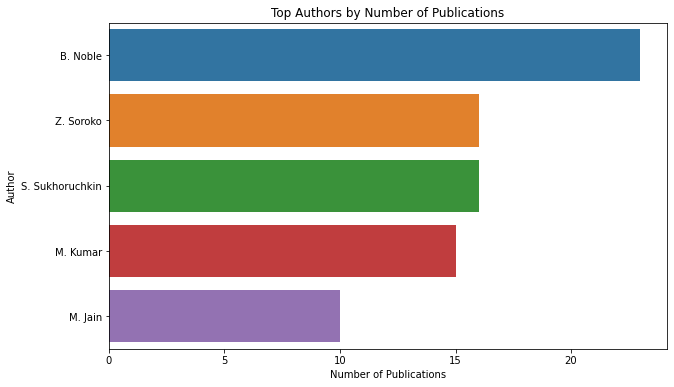

In [0]:
five_authors = publication.withColumn("author", F.explode(publication.authors))\
        .groupBy("author")\
        .count()\
        .orderBy(F.desc("count"))\
        

#transform our top_authors df to pandas df for visualisation 
five_authors_pd = five_authors.toPandas()

# Extract 'name' from the dictionary in 'author' column
five_authors_pd['author_name'] = five_authors_pd['author'].apply(lambda x: x['name'])

# Create a new DataFrame with only the 'name' information
five_authors_df_1 = five_authors_pd[['author_name', 'count']]

# Rename columns
five_authors_df_1.columns = ['Author Name', 'Count of Publications']

plt.figure(figsize=(10, 6))
sns.barplot(x="Count of Publications", y="Author Name", data=five_authors_df_1.head(5)) 
plt.xlabel("Number of Publications")
plt.ylabel("Author")
plt.title("Top Authors by Number of Publications")
plt.show()

#### Q5: Find the top 5 authors with the highest cummulative impact factor (notice that journals have different impact factors listed in the journal file in the IF column). Output both the author information and the cummulative impact factor.

In [0]:
def high_if(df,df2):
    publication_5 = (
        df.withColumn("author", F.explode(F.col('authors')))
        .withColumn("Journal_Name", expr("journal.name"))
        .select("Journal_Name", "author")
    )

    joined_df = publication_5.join(
        df2,
        publication_5["Journal_Name"] == df2["Journal_Name"],
        "inner",
    )

    result_q5 = (
        joined_df.select("author", "IF")
        .groupBy("author")
        .sum("IF")
        .orderBy("sum(IF)", ascending=False)
    )
    return result_q5

In [0]:
high_if(publication,journal_processed).show(5)

+--------------------+-----------------+
|              author|          sum(IF)|
+--------------------+-----------------+
|{2155504929, Ying...|93.83199691772461|
|{144797099, M. Vi...|92.23799896240234|
|{5152451, L. Andr...|92.23799896240234|
| {49900836, H. Wood}| 90.4219970703125|
|{7695437, A. M. R...| 87.8989987373352|
+--------------------+-----------------+
only showing top 5 rows



#### Visualisation

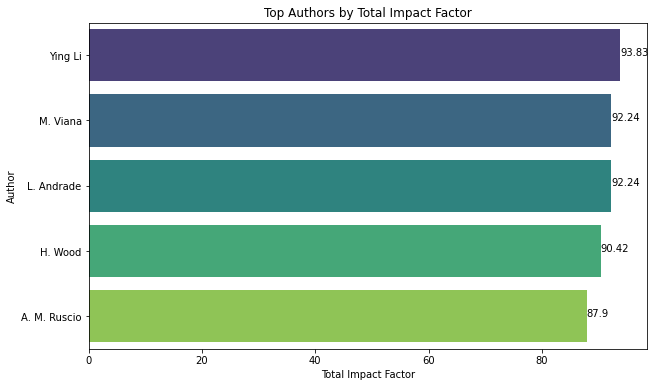

In [0]:
publication_5 = publication.withColumn("author", F.explode(F.col('authors')))\
        .withColumn("Journal_Name", expr("journal.name"))\
        .select("Journal_Name", "author")

joined_df = publication_5.join(
        journal_processed,
        publication_5["Journal_Name"] == journal_processed["Journal_Name"], "inner")

result_q5 = joined_df.select("author", "IF")\
        .groupBy("author")\
        .sum("IF")\
        .orderBy("sum(IF)", ascending=False)


result_q5_pd = result_q5.toPandas()

result_q5_pd['author_name'] = result_q5_pd['author'].apply(lambda x: x['name'])
result_q5_pd_1 = result_q5_pd[['author_name', 'sum(IF)']]
result_q5_pd_1.columns = ['Author Name', 'sum(IF)']

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='sum(IF)', y='Author Name', data=result_q5_pd_1.head(5), palette='viridis')  
plt.xlabel('Total Impact Factor')
plt.ylabel('Author')
plt.title('Top Authors by Total Impact Factor')

for index, value in enumerate(result_q5_pd_1.head(5)['sum(IF)']):
    ax.text(value, index, str(round(value, 2)), color='black', ha="left")

plt.show()

#### Q6: You’d like some additional information about publication trends. How many publications with impact factor > 1 were published in each of the years between 2010-2020? Ensure that your answer for each year is visible in your report.

In [0]:
def if_20102020(df, df2):
    publication_6 = df.select(
        "corpusid", "year", F.col("journal.name").alias("Journal_Name")
    )

    journal_filtered_6 = df2.withColumnRenamed("Journal_Name","Journal__Name").select("Journal__Name", "IF")

    joined_df_6 = publication_6.join(
        journal_filtered_6,
        publication_6["Journal_Name"] == journal_filtered_6["Journal__Name"],
        "inner",
    ).select("year", "Journal_Name", "corpusid")

    result_q6 = (
        joined_df_6.filter(F.col("IF") > 1)
        .filter((F.col("year") >= 2010) & (F.col("year") <= 2020))
        .groupBy("year")
        .agg(F.count("corpusid"))
        .orderBy("year")
    ) 
    return result_q6

In [0]:
if_20102020(publication,journal_processed).show()

+----+---------------+
|year|count(corpusid)|
+----+---------------+
|2010|            112|
|2011|            139|
|2012|            165|
|2013|            178|
|2014|            241|
|2015|            243|
|2016|            283|
|2017|            329|
|2018|            365|
|2019|            396|
|2020|            444|
+----+---------------+



#### Visualisation

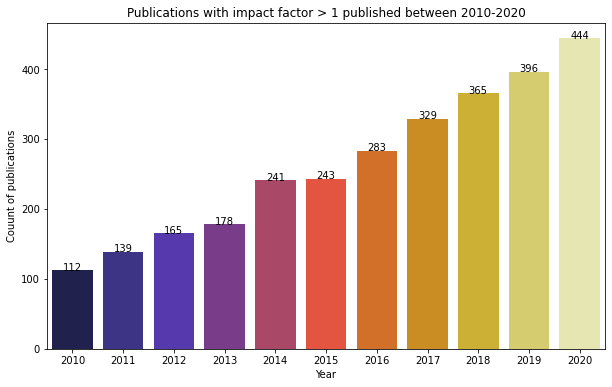

In [0]:
publication_6 = publication.select(
        "corpusid", "year", F.col("journal.name").alias("Journal_Name")
    )

journal_filtered_6 = journal_processed.withColumnRenamed("Journal_Name","Journal__Name").select("Journal__Name", "IF")

joined_df_6 = publication_6.join(
        journal_filtered_6,
        publication_6["Journal_Name"] == journal_filtered_6["Journal__Name"],
        "inner").select("year", "Journal_Name", "corpusid")

result_q6 = joined_df_6.filter(F.col("IF") > 1)\
        .filter((F.col("year") >= 2010) & (F.col("year") <= 2020))\
        .groupBy("year")\
        .agg(F.count("corpusid"))\
        .orderBy("year")

result_q6_pd = result_q6.toPandas()


result_q6_pd_1 = result_q6_pd[['year', 'count(corpusid)']]
result_q6_pd_1.columns = ['Year', 'count(corpusid)']

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Year', y='count(corpusid)', data=result_q6_pd_1.head(11), palette='CMRmap')  
plt.xlabel('Year')
plt.ylabel('Couunt of publications')
plt.title('Publications with impact factor > 1 published between 2010-2020')

for index, value in enumerate(result_q6_pd_1.head(11)['count(corpusid)']):
    ax.text(index, value, str(value), color='black', ha="center")

plt.show()

## PySpark SQL

#### Data preparation 

In [0]:
spark.read.option('header', True).json('/FileStore/tables/large_json.gz').createOrReplaceTempView('publication_temp_table')

journal_processed.createOrReplaceTempView("journal_processed_temp_table")

#### Q1

In [0]:
distinct_count_result = spark.sql('select count(distinct(corpusid)) from publication_temp_table')
distinct_count_result.show()

+------------------------+
|count(DISTINCT corpusid)|
+------------------------+
|                  150000|
+------------------------+



#### Q2

In [0]:
# Calculate the average number of authors per paper
authors_per_paper = spark.sql("""
    SELECT AVG(size(author_name)) AS authors_per_paper
    FROM (
        SELECT TRANSFORM(authors, x -> x.name) AS author_name
        FROM publication_temp_table
    )
""").first()[0]


authors_per_paper

Out[278]: 2.81628

#### Q3

In [0]:
publication_3_sql = spark.sql(
    """
    SELECT COUNT(DISTINCT journal.name) AS distinct_count
    FROM publication_temp_table
    WHERE journal.name IS NOT NULL AND journal.name != ''
    """
)

publication_3_sql.show()

+--------------+
|distinct_count|
+--------------+
|         33916|
+--------------+



#### Q4

In [0]:
top_authors_sql = spark.sql("""
    SELECT
        author,
        COUNT(*) AS count
    FROM (
        SELECT
            EXPLODE(authors) AS author
        FROM
            publication_temp_table
    ) 
    GROUP BY
        author
    ORDER BY
        count DESC
    LIMIT 5
""")

top_authors_sql.display()

author,count
"List(2149377746, B. Noble)",23
"List(90537224, S. Sukhoruchkin)",16
"List(88842366, Z. Soroko)",16
"List(49898687, M. Kumar)",15
"List(49611617, M. Jain)",10


#### Q5

In [0]:
result_q5_sql = spark.sql(
    """
SELECT PB.authors,sum(JL.IF)
FROM(
    SELECT
        journal.name AS Journal_Name,
        explode(authors) as authors 
    FROM 
        publication_temp_table
        ) AS PB
 
JOIN journal_processed_temp_table as JL
ON PB.Journal_Name == JL.Journal_Name
GROUP BY authors 
ORDER BY sum(IF) DESC 
"""
)

# Show the result
result_q5_sql.show(5)

+--------------------+-----------------+
|             authors|          sum(IF)|
+--------------------+-----------------+
|{2155504929, Ying...|93.83199691772461|
|{144797099, M. Vi...|92.23799896240234|
|{5152451, L. Andr...|92.23799896240234|
| {49900836, H. Wood}| 90.4219970703125|
|{7695437, A. M. R...| 87.8989987373352|
+--------------------+-----------------+
only showing top 5 rows



#### Q6

In [0]:
resut_q6_sql = spark.sql("""
SELECT year, COUNT(corpusid) AS publication_count
FROM (
    SELECT p.corpusid, p.year, j.IF
    FROM publication_temp_table p
    JOIN journal_processed_temp_table j 
    ON p.journal.name == j.Journal_Name
    WHERE j.IF > 1 AND p.year BETWEEN 2010 AND 2020
) AS joined_data
GROUP BY year
ORDER BY year
""")

resut_q6_sql.show()

+----+-----------------+
|year|publication_count|
+----+-----------------+
|2010|              112|
|2011|              139|
|2012|              165|
|2013|              178|
|2014|              241|
|2015|              243|
|2016|              283|
|2017|              329|
|2018|              365|
|2019|              396|
|2020|              444|
+----+-----------------+

